# Azure Cognitive Services: Custom Vision

  References: 
  * Portal: [https://www.customvision.ai/](https://www.customvision.ai/)
  * SDK: [https://docs.microsoft.com/pt-br/azure/cognitive-services/custom-vision-service/quickstarts/image-classification?tabs=visual-studio&pivots=programming-language-python](https://docs.microsoft.com/pt-br/azure/cognitive-services/custom-vision-service/quickstarts/image-classification?tabs=visual-studio&pivots=programming-language-python)
  * APIs:
    - Custom Vision Training: [https://westus2.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3/](https://westus2.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3/)
    - Custom Vision Prediction: [https://eastus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Prediction_3.1/](https://eastus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Prediction_3.1/)
  * This code was adapted from [AI-102-AIEngineer: 17-image-classification](https://github.com/MicrosoftLearning/AI-102-AIEngineer/tree/master/17-image-classification)


In [2]:
!pip install azure-cognitiveservices-vision-customvision

In [51]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
from os import path
from dotenv import load_dotenv

from sklearn import metrics
import requests
import os
import yaml

import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

from sklearn.metrics import confusion_matrix


In [52]:
cwd = os.getcwd()
project_dir =os.path.abspath(os.path.join(cwd, os.path.join(os.pardir, os.pardir)))
config_file = os.path.join(project_dir, "Config", "config.yaml")
print(config_file)

with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)


c:\Users\anacarolines\OneDrive - Microsoft\Projetos\aiops-customvision\Config\config.yaml


In [73]:
train_endpoint = config['cv']['TrainingEndpoint']
training_key = config['cv']['TrainingKey']
project_id = config['cv']['ProjectID']
pred_endpoint = config['cv']['PredictionEndpoint']
prediction_key = config['cv']['PredictionKey']
prediction_resource_id = "/subscriptions/8d47f388-3a7a-4970-9dec-2c6cc53e02a9/resourceGroups/rg_chihuahua_muffin/providers/Microsoft.CognitiveServices/accounts/cmcustomvision-prediction"

project_name = 'fruit-classifier4'
publish_iteration_name = "v0"
path_training_images = os.path.join(project_dir, "Deploy", "training-images")

Authenticate the client


In [61]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(train_endpoint, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(pred_endpoint, prediction_credentials)

## Create a new Custom Vision project


In [86]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})


def create_project(project_name):
    # Create a new project
    print ("Creating project...")
    return trainer.create_project(project_name)

def delete_project(project_id):
    print ("Deleting project...")
    trainer.delete_project(project_id)
    
def get_projects():
    return trainer.get_projects(raw=True).response.json()


In [87]:
[i['name'] for i in get_projects()]

['fruit-classifier3', 'fruit-classifier2', 'chihuahua-muffin']

In [88]:
#trainer.unpublish_iteration(project.id, iteration.id)
#trainer.delete_project(trainer.get_projects()[0].id)
project = trainer.create_project(project_name)

# ------> Adicionar o project id no config.yaml
print(project.id)


b58b8486-1acd-4236-aa29-b9d4ac2ce906


In [90]:
[i['name'] for i in get_projects()]

['fruit-classifier4',
 'fruit-classifier3',
 'fruit-classifier2',
 'chihuahua-muffin']

## Add tags to the project


In [91]:
def get_dir_names(path_training_images):
    return [dI for dI in os.listdir(path_training_images) 
        if os.path.isdir(os.path.join(path_training_images,dI))]


In [92]:
tags = get_dir_names(path_training_images)
print(tags)

['apple', 'banana', 'orange']


In [93]:
def get_tags(project_id):
    tags = list()
    for i in trainer.get_tags(project_id):
        tags.append( i.name)
    return tags

def create_tags (project_id, tags):
    for i in tags:
        if i not in get_tags(project.id):
            trainer.create_tag(project.id, i)

In [94]:
get_tags(project.id)

[]

In [95]:
create_tags(project.id, tags)

In [96]:
get_tags(project.id)

['orange', 'apple', 'banana']

## Upload images


In [97]:
def upload_images(folder):
    print("Uploading images...")
    tags = trainer.get_tags(project.id)
    for tag in tags:
        print(tag.name)
        for image in os.listdir(os.path.join(folder,tag.name)):
            image_data = open(os.path.join(folder,tag.name,image), "rb").read()
            trainer.create_images_from_data(project.id, image_data, [tag.id])


In [98]:
upload_images(path_training_images)

Uploading images...
orange
apple
banana


## Train Model

In [99]:
def train_model():
    print("Training ...")
    #:param training_type: The type of training to use to train the project
    #     (default: Regular). Possible values include: 'Regular', 'Advanced'
    iteration = trainer.train_project(project.id)
    while (iteration.status != "Completed"):
        iteration = trainer.get_iteration(project.id, iteration.id)
        print (iteration.status, '...')
        time.sleep(10)
    print ("Model trained!")
    print ("Iteration id: " + iteration.id)
    print ("Iteration name: " + iteration.name)
    return iteration

In [100]:
iteration = train_model()

Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Completed ...
Model trained!
Iteration id: ef230bb5-15a7-4b18-a1c0-2bb5a8824826
Iteration name: Iteration 1


## Model Evaluation


In [ ]:
training_results = trainer.get_image_performances(project.id, iteration.id,raw=True).response.json()
total_imgs = trainer.get_tagged_image_count(project.id)

y_true = []
y_pred = []
for i in training_results:
    y_pred.append(i["predictions"][0]["tagName"])
    y_true.append(i["tags"][0]["tagName"]) 

print(y_true)
print(y_pred)

print("\nTotal Images: " + str(total_imgs))
print("Trained Images: " + str(len(training_results)))
print("Splitted Train/Test: {}/{}".format(str(100-int(len(training_results)*100/total_imgs)),str(int(len(training_results)*100/total_imgs))))

In [ ]:
len(training_results)

In [103]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


['banana', 'banana', 'banana', 'apple', 'apple', 'apple', 'orange', 'orange', 'orange']
['banana', 'banana', 'banana', 'apple', 'apple', 'apple', 'orange', 'orange', 'orange']

Total Images: 45
Trained Images: 9
Splitted Train/Test: 80/20


9

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00         3
      banana       1.00      1.00      1.00         3
      orange       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion matrix, without normalization
[[3 0 0]
 [0 3 0]
 [0 0 3]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


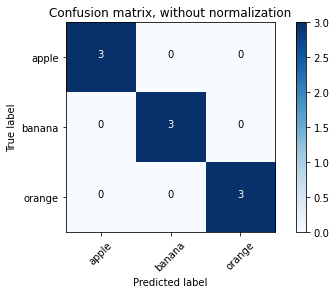

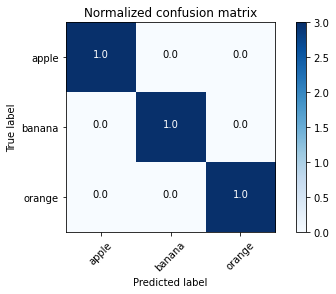

In [104]:
print(metrics.classification_report(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = sorted(set(y_true))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Publish the current iteration


In [105]:
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)


True

## Test the prediction endpoint


In [112]:
# Classify test images
test_img_dir = os.path.join(project_dir,'Deploy','test-images')
print(test_img_dir)
for image in os.listdir(test_img_dir):
    image_data = open(os.path.join(test_img_dir,image), "rb").read()
    print(project.id)
    results = predictor.classify_image(project.id, publish_iteration_name, image_data)
    #print(results)
    # Loop over each label prediction and print any with probability > 50%
    for prediction in results.predictions:
        if prediction.probability > 0.2:
            print(image, ': {} ({:.0%})'.format(prediction.tag_name, prediction.probability))


c:\Users\anacarolines\OneDrive - Microsoft\Projetos\aiops-customvision\Deploy\test-images
b58b8486-1acd-4236-aa29-b9d4ac2ce906
IMG_TEST_1.jpg : apple (100%)
b58b8486-1acd-4236-aa29-b9d4ac2ce906
IMG_TEST_2.jpg : banana (100%)
b58b8486-1acd-4236-aa29-b9d4ac2ce906
IMG_TEST_3.jpg : orange (100%)
b58b8486-1acd-4236-aa29-b9d4ac2ce906
IMG_TEST_4.jpg : apple (58%)


In [113]:
get_tags(project.id)

['orange', 'apple', 'banana']

In [133]:
# Printar as tags que o modelo previu através do endpoint acime de 80% de prob
#limite de duas queries por vez
tags_ids = [t['id'] for t in trainer.get_tags(project.id, raw=True).response.json()]
queries = []
query_pred_bytags = {}
query_pred_bytags['tags'] = []
coringa = []
threshold = 0.1
counter = 1

for i in tags_ids:
    tags = []
    tags.append({"id" : i,
            "minThreshold" : threshold})
    queries.append({"tags" : tags } )
print (queries)
print(len(queries))

[{'tags': [{'id': 'ed1518fc-7efe-4eb4-a8a4-569d16804510', 'minThreshold': 0.8}]}, {'tags': [{'id': 'fa5e6c9c-c0d7-43c8-8b2c-bf9488dcae44', 'minThreshold': 0.8}]}, {'tags': [{'id': 'f3379d05-f484-457f-97c4-f75998206ebb', 'minThreshold': 0.8}]}]
3
